In [51]:
import pandas as pd
import unidecode
import re

In [91]:
def clean_col_names(df_):

    df = df_.copy()
    cols = df.columns.to_list()
    new_cols=[]
    for col in cols:
        
        col = re.sub(' +', ' ', col)
        col = col.replace(' ','_')
        col = col.replace('/','')
        col = col.replace('$','dollar')
        col = col.upper()
        new_cols.append(col)

    df.columns = new_cols

    return df
    
def stdr_names(series_original):
    '''Clean company names. To be used in the different files so names are likelier to be matched'''
    series = series_original.copy()
    series = series.astype(str)
    
    series = series.str.upper()
    series = series.str.strip()

    series = series.replace(r'\s+', ' ', regex=True)
    series = series.str.replace(r'[^\w\s]+', '', regex=True)


    series = series.apply(lambda x: unidecode.unidecode(x))

    series = series.str.replace(' QUEBEC ', '')
    series = series.str.replace('CANADA', '')
    series = series.str.replace(' MONTREAL ', '')
    series = series.str.replace('MONTREAL ', '')
    series = series.str.replace(' MONTREAL', '')
    series = series.str.replace(' INC', '')
    series = series.str.replace(' INC ', '')
    series = series.str.replace(' CIE ', '')
    series = series.str.replace(' CIE', '')
    series = series.str.replace(' LTEE', '')
    series = series.str.replace('CORPORATION', '')
    series = series.str.replace('INTERNATIONAL', '')
    return series

In [246]:
df_donors = pd.read_csv('../Data/past_donors_clean.csv')
df_orgs = pd.read_excel('../Data/Organizations_stg.xlsx') # 1342 but 1337 different names

df_donors=clean_col_names(df_donors)
df_orgs=clean_col_names(df_orgs)

df_donors = df_donors[['COMPANY']].drop_duplicates().reset_index(drop=True)

# now we read the matches after reviews them and this will become our key to match both sources
df_matches = pd.read_excel('../Data/matched_orgs_k4kreview.xlsx')

df_donors['COMPANY_STD'] = stdr_names(df_donors.COMPANY)
df_orgs['COMPANY_STD'] = stdr_names(df_orgs.NAME)

In [247]:
df_orgs = df_orgs.drop(columns = ['ISFOUNDATION'])

df_fonds = pd.read_excel('../Data/Foundations_stg.xlsx')
df_fonds = clean_col_names(df_fonds)
df_fonds['HASFOUNDATION'] = 1

df_orgs = df_orgs.merge(df_fonds[['ID', 'HASFOUNDATION']], how='left', on='ID')
df_orgs.HASFOUNDATION.fillna(0, inplace=True)

In [328]:
df_fonds.columns

Index(['ID', 'ACTIF', 'ADDRESS', 'AVIS', 'CATEGORIE', 'CONTACT', 'COURRIEL',
       'DATE_APPROB', 'DATE_FIN_DANN', 'DOMAINES_DINTERET', 'ECHELLEDONS',
       'ISFOUNDATION', 'LANGUE', 'LIMITES_GEOG', 'N_DE_TEL', 'NAME', 'OU',
       'POSTE', 'PROJETS_PRIVILEGIES', 'TEL', 'TOTAL_ANNUEL', 'WEB',
       'MUNICIPALITY', 'PROVINCE', 'POSTALCODE', 'STREET', 'HASFOUNDATION'],
      dtype='object')

In [248]:
df_matches = df_matches[df_matches.Match == 1] # keeping only matches
df_matches = df_matches.iloc[:, 0:2]
df_matches.columns = ['ORGANIZATION', 'DONOR']

In [249]:
# some past donors have been matched with more than 1 different company in the PDF source, so we need to select and keep only one so the analysis is consistent.
donor_q = df_matches.DONOR.value_counts()
organization_q = df_matches.ORGANIZATION.value_counts()
df1 = df_matches[df_matches.DONOR.isin(donor_q[donor_q > 1].index)].sort_values('DONOR').reset_index(drop=True)

ixs = [1, 2,5,6,10,11,15,16,18, 21,22] 
df1 = df1.iloc[ixs,:].reset_index(drop=True)

In [250]:
# now we concatenate the matches into a single df
df_matches = pd.concat([ df_matches[df_matches.DONOR.isin(donor_q[donor_q <= 1].index)].sort_values('DONOR').reset_index(drop=True),
            df1 ] )

In [251]:
df_donors['FLG_PAST_DONOR'] = 1

In [252]:
df_donors_match = df_donors.merge(df_matches, how = 'inner', left_on = 'COMPANY_STD', right_on = 'DONOR')

In [253]:
df_donors_match2 = df_donors_match.merge(df_orgs, how = 'right', left_on = 'ORGANIZATION', right_on = 'COMPANY_STD')

# after matching, flag the ones in past donors

## modify so we kee the original name somewhere, or cross by ID to avoid duplicating rows

In [254]:
df_donors_match2 = df_donors_match2.drop(columns  =[ 'COMPANY', 'COMPANY_STD_x', 'ORGANIZATION', 'DONOR', 'COMPANY_STD_y' ] )

In [255]:
df_donors_match2.NAME.nunique()

1337

In [256]:
df_donors_match2.shape

(1348, 50)

In [257]:
df_donors_match2 = df_donors_match2.drop_duplicates().reset_index(drop=True)

df_donors_match2.FLG_PAST_DONOR = df_donors_match2.FLG_PAST_DONOR.fillna(0)


In [283]:
df = df_donors_match2[ ['NAME','ID',
'FLG_PAST_DONOR',
       'FILIALE_DE', 
       'HASFOUNDATION', 
        'LIMITES_GEOG',
         'NOMBRE_DEMPLOYES',
       'PRINCIP_FILIALES', 
       'SECTOR_FABRICATION', 'SECTOR_FINANCIERS', 'SECTOR_COMMERCE',
       'SECTOR_CONSTRUCTION', 'SECTOR_TRANSPORT', 'SECTOR_GESTION',
       'SECTOR_SYSTEMS', 'SECTOR_ALIMENTATION', 'SECTOR_SANTE_ASSURANCE',
       'SECTOR_OTHER', 'GENERAL_CHARITY',
       'HEALTH_ARTS_CULTURE', 'COMMUNITY_ENVIRONMENTAL',
       'YOUTH_HEALTH_EDUCATION', 'REGIONAL_SPECIFIC',
       'CANCER_DISEASE_RESEARCH'         
         ]].drop_duplicates().reset_index(drop=True)

In [284]:
df['FILIALE_FLG'] = df.FILIALE_DE.notna().astype(int)


In [285]:
df.LIMITES_GEOG = df.LIMITES_GEOG.str.strip('.').astype(str)

mapper = { 'locales, régionales et nationales' :'regional and national',
'locales' : 'locals',
'nationales' : 'nationals',
'régionales' :'regionals',
'nationales, régionales au Québec' : 'regional and national',
'régionales et nationales' : 'regional and national',
'locales, régionales':'local and regional',
'locales et régionales':'local and regional',
'locales, nationales et internationales':'international',
'nan':'nan',
'nationales et internationales':'international'}

df.LIMITES_GEOG = df.LIMITES_GEOG.map(mapper)

In [286]:
df['FILIALE_FLG2'] = df.PRINCIP_FILIALES.notna().astype(int)

In [287]:
df.NOMBRE_DEMPLOYES = df.NOMBRE_DEMPLOYES.astype(str).str.replace(' ','').astype(float)

In [288]:
df = df.drop(columns = ['PRINCIP_FILIALES', 'FILIALE_DE' ])

In [289]:
df.HASFOUNDATION.value_counts()

0.0    1264
1.0      78
Name: HASFOUNDATION, dtype: int64

In [290]:
cols_to_encode = ['LIMITES_GEOG']
dummies = pd.get_dummies(df[cols_to_encode])

df = pd.concat( [df, dummies], axis = 1).drop(columns = cols_to_encode)

In [291]:
from sklearn.preprocessing import StandardScaler

df.NOMBRE_DEMPLOYES.fillna(0, inplace=True)

scaler = StandardScaler()
df.NOMBRE_DEMPLOYES = scaler.fit_transform(df[['NOMBRE_DEMPLOYES']])

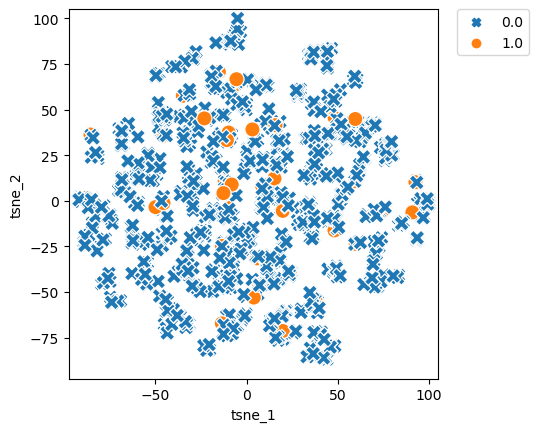

In [282]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_x = df.iloc[:,3:]
y = df['FLG_PAST_DONOR'].to_numpy()
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, perplexity = 5)
tsne_result = tsne.fit_transform(df_x)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images

 # Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', style = 'label', style_order = [1,0], data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [293]:
df_x = df.loc[df.FLG_PAST_DONOR == 0].reset_index(drop=True)

df_y = df.loc[df.FLG_PAST_DONOR == 1].reset_index(drop=True)

In [294]:
df_x

,NAME,ID,FLG_PAST_DONOR,HASFOUNDATION,NOMBRE_DEMPLOYES,SECTOR_FABRICATION,SECTOR_FINANCIERS,SECTOR_COMMERCE,SECTOR_CONSTRUCTION,SECTOR_TRANSPORT,...,CANCER_DISEASE_RESEARCH,FILIALE_FLG,FILIALE_FLG2,LIMITES_GEOG_international,LIMITES_GEOG_local and regional,LIMITES_GEOG_locals,LIMITES_GEOG_nan,LIMITES_GEOG_nationals,LIMITES_GEOG_regional and national,LIMITES_GEOG_regionals
0,3M Canada inc.,1,0.0,0.0,-0.224658,1,0,0,0,0,...,0.02,0,0,0,0,0,0,0,0,1
1,A & D Prévost,2,0.0,0.0,-0.193808,1,0,0,1,0,...,0.69,0,0,0,0,1,0,0,0,0
2,AAR Aicraft - Services Trois-Rivières,3,0.0,0.0,-0.150618,0,0,0,1,0,...,0.03,0,0,0,0,0,0,1,0,0
3,ABB (Albert Bob Bob),4,0.0,0.0,-0.206148,1,0,0,0,0,...,0.04,1,0,0,0,1,0,0,0,0
4,ABB Canada,5,0.0,0.0,0.176397,1,0,1,0,1,...,0.01,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,Xérox Canada,1338,0.0,1.0,-0.116682,1,1,1,0,0,...,0.02,0,1,0,0,0,0,1,0,0
1283,Yamaha Moteur du Canada Ltée,1339,0.0,0.0,-0.255509,1,0,0,0,0,...,0.32,1,0,0,0,0,0,0,0,1
1284,"Yum Yum Enr., Les croustilles",1340,0.0,0.0,-0.178383,1,0,0,0,0,...,0.27,0,0,0,0,0,0,0,0,1
1285,(CEZinc),1341,0.0,0.0,-0.087374,0,0,0,1,0,...,0.01,0,0,0,0,1,0,0,0,0


In [320]:
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')

df_scores_acum  = pd.DataFrame( columns = ['org', 'past_donor','SCORE'])
for _, r in df_x.iterrows():

    scores = []

    org = r['NAME']
    org_id = r[1]    
    vec_x = r.to_list()[3:]

    for _, r2 in df_y.iterrows():
        past_donor = r2['NAME']
        past_donor_id = r2['ID']
        vec_y = r2.to_list()[3:]

        similarity =  1 - spatial.distance.cosine(vec_x, vec_y)
        scores.append( [org, org_id, past_donor , similarity] )

    df_scores = pd.DataFrame(data = scores, columns = ['org','id','past_donor', 'SCORE']).nlargest(4, columns ='SCORE')
    df_scores = df_scores.append({'org':org, 'id': org_id, 'past_donor':'4_CLOSEST_AVERAGE', 'SCORE': df_scores.SCORE.mean()}, ignore_index=True)

    df_scores_acum = pd.concat([df_scores_acum, df_scores])
    
df_scores_acum= df_scores_acum.reset_index(drop=True)

    


In [321]:
df_sample = df_scores_acum[df_scores_acum.past_donor == '4_CLOSEST_AVERAGE'].sort_values('SCORE', ascending=False).head(80).sample(10)

In [322]:
df_scores_acum[df_scores_acum.org.isin(df_sample.org.to_list())]

,org,past_donor,SCORE,id
1075,Campbell du Canada,"Labatt,",0.976089,227.0
1076,Campbell du Canada,Sleeman Unibroue Québec,0.825077,227.0
1077,Campbell du Canada,"Aliments Dare ltée,",0.704625,227.0
1078,Campbell du Canada,Aliments Maple Leaf,0.636205,227.0
1079,Campbell du Canada,4_CLOSEST_AVERAGE,0.785499,227.0
1830,Discount,AVIS Location de voitures,0.879241,389.0
1831,Discount,"Delmar inc.,",0.826162,389.0
1832,Discount,Via Rail Canada,0.782883,389.0
1833,Discount,"Labrie,",0.750623,389.0
1834,Discount,4_CLOSEST_AVERAGE,0.809727,389.0


In [323]:
df_scores_avg = df_scores_acum[df_scores_acum.past_donor == '4_CLOSEST_AVERAGE']

In [324]:
df_final = df_donors_match2.merge(df_scores_avg[['id', 'SCORE']], how = 'left', left_on = 'ID', right_on = 'id' ).drop(columns = ['id'])

In [325]:
df_final['MAIN_TOPIC'] = df_final[[ 'GENERAL_CHARITY',	'HEALTH_ARTS_CULTURE'	,'COMMUNITY_ENVIRONMENTAL',	'YOUTH_HEALTH_EDUCATION',	'REGIONAL_SPECIFIC'	,'CANCER_DISEASE_RESEARCH']].idxmax(axis=1)

In [333]:
df_final = df_final [['ID', 'NAME', 'FLG_PAST_DONOR', # identifier
 'ADDRESS', 'MUNICIPALITY', 'PROVINCE','POSTALCODE', 'STREET', #location info
'CONTACT', 'N_DE_TEL',  'COURRIEL', # important contact info

'2E_CONTACT_POUR', 'AVIS', 'DDD',  'FAF', 'FAX',  'LANGUE',  'SITE_WEB',   'NOTE', 'POSTE', 'CONTRIBUTION', # typically not important columns
'FILIALE_DE', 'LIMITES_GEOG',   'NBRE_DE_SUCC', 'NOMBRE_DEMPLOYES', 'PRINCIP_FILIALES', 'HASFOUNDATION', 'SECTEUR_INDUSTRIEL',  'DOMAINE_DINTERET',# descriptives of the company 

# analytical features
'SECTOR_FABRICATION', 'SECTOR_FINANCIERS', 'SECTOR_COMMERCE',
 'SECTOR_CONSTRUCTION', 'SECTOR_TRANSPORT','SECTOR_GESTION', 
 'SECTOR_SYSTEMS', 'SECTOR_ALIMENTATION', 'SECTOR_SANTE_ASSURANCE', 
 'SECTOR_OTHER','INTEREST_DOMAIN_CLEAN','MAIN_TOPIC','MAIN_TOPIC_SCORE', 'SECONDARY_TOPIC', 'SECONDARY_TOPIC_SCR','SCORE'
 ] ]

In [335]:
df_final.rename(columns = {'SCORE':'SIMILARITY_SCORE'},inplace=True)

In [339]:
df_final.to_excel('../Data/Organizations_scored.xlsx', index=None)

In [340]:
df_final.head(5).to_clipboard()

In [2]:
import pandas as pd

df = pd.read_excel('../Data/Organizations_scored.xlsx' ) 

In [35]:

df [ df.MAIN_TOPIC == 'CANCER_DISEASE_RESEARCH'].NAME.sample(40)

1263                                 Trévi
495                    Ford du Canada Ltée
880      MRRM Inc. / Aliments Dainty Foods
343                Courchesne, Larose ltée
504                        Franklin Empire
60                                Alithya,
101           Atrahan Transformation inc.,
637             IGA Lambert & Frères Inc.,
65                               Allstream
505             Freeman Audiovisuel Canada
1060              Restaurants Boston Pizza
568                               Groleau,
492     Fonds d'investissement Renaissance
1                            A & D Prévost
1069                      Richter Montréal
1211                 Tapis Venture Limitée
187                            Bonneville,
1059                 Restaurant Valentine,
280                                Markets
1064               Restaurants Pacini Inc.
1006                    Procom Québec Inc.
707      L'Excellence, Cie d'assurance-vie
184           Boisvert Chevrolet Buick GMC
1095       